# Exercise 1: Linear Image Classifier

In this exercise you will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python. This exercise has 2 parts:

1. Implementing loss functions, calculating gradients and implementing gradient descent.
2. Training and evaluating several classifiers.

## Submission guidelines:

Your submission should only include this jupyter notebook named ex1_ID.ipynb.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever instructed. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in this jupyter notebook only.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only in your implementations. Any other imports are forbidden.
6. Your code must run without errors.
7. Write your own code. Cheating will not be tolerated. 
8. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

Q: What files do we need to upload to moodle?

A: 

Q: Should you run your code and make sure everything works just before you submit? What will happen if your code cannot run?

A:

Q: Should you add any other files in your submission?

A:

#### Imports

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data preprocessing


## Data download and processing Helper Code

In [2]:
def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Limit it because rounding errors may cause it to exceed 100%.
    pct_complete = min(1.0, pct_complete)

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

def download(base_url, download_dir):
    """
    Download the given file if it does not already exist in the download_dir.
    :param base_url: The internet URL without the filename.
    :param filename: The filename that will be added to the base_url.
    :param download_dir: Local directory for storing the file.
    :return: Nothing.
    """

    # Path for local file.
    filename = base_url.split("/")[-1]
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=base_url,
                                                  filename=save_path,
                                                  reporthook=_print_download_progress)

        print(" Done!")

def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")

def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

The next cell will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [3]:
# this cell will download the data if it does not exists
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.


## Data Preprocessing Part 1

We have included several image processing functions. Notice the following in particular: we created an additional validation dataset you need to use for hyperparameter optimization.

In [4]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH) # load the entire data

# taking only two classes from the dataset
X_train = X_train[np.logical_or(y_train == 0, y_train == 1)]
y_train = y_train[np.logical_or(y_train == 0, y_train == 1)]
X_test = X_test[np.logical_or(y_test == 0, y_test == 1)]
y_test = y_test[np.logical_or(y_test == 0, y_test == 1)]

# define a splitting for the data
num_training = 10000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

classes = ('plane', 'car')

    plane     plane     plane       car


<ipython-input-5-53f36cc3ba39>:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid = np.hstack(np.array([np.asarray(i, dtype=np.int) for i in images]))


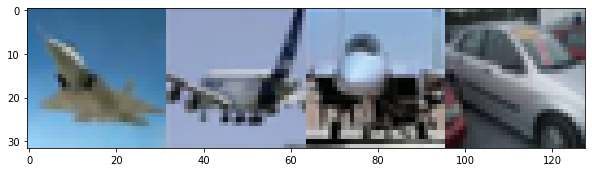

In [5]:
def get_batch(X, y, n=1000):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels

def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    if random_flag:
      rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
      rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
      grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images]))
    else:
      grid = np.hstack(np.array([np.asarray(i, dtype=np.int) for i in images]))
    print(' '.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, convert_to_image=False));

## Data Preprocessing Part 2

We have included several image processing functions. Notice the following in particular: We subtracted the mean from all the images in order to ignore illumination conditions while keeping the content of the image. Next, we flattened the images from a tensor of shape (32x32x3) to a vector with 3072 features (pixel values) so we would be able to use a simple matrix multiplication. Finally, we concatenated each image vector with an additional feature to account for the bias. This is known as the bias trick. 

Make sure you understand this image processing pipeline before diving into the rest of the code.

In [6]:
# Final data preprocessing
# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(f"Shape of Training Set: {X_train.shape}")
print(f"Shape of Validation Set: {X_val.shape}")
print(f"Shape of Test Set: {X_test.shape}")

Shape of Training Set: (10000, 3073)
Shape of Validation Set: (1000, 3073)
Shape of Test Set: (1000, 3073)


# Linear classifier: mapping images to scores

During this exercise, we will maintain a python class with basic functionality (such as training the model). the linear classifiers we will build (perceptron, logistic regression) will inherit some functionality from that class and will change several functions (such as the loss function, for example). Read the code in the next cell and make sure you understand it. You might also find this [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) useful.


In [7]:
class LinearClassifier(object):
    def __init__(self, X, y):
        """
        Class constructor. Use this method to initiate the parameters of
        your model (W)
        *** Subclasses will override this. ***

        Inputs:
        - X: array of data
        - y: 1-dimensional array of length N with binary labels

        This function has no return value

        """
        num_features = X.shape[1]
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        self.W = 0.0001 * np.random.randn(num_features, num_classes)        

    def predict(self, X):
        """
        Use the weight of the classifier to predict a label. 
        *** Subclasses will override this. ***

        Input: 2D array of size (num_instances, num_features).
        Output: 1D array of class predictions (num_instances, 1). 
        """
        pass

    def calc_accuracy(self, X, y):
        """
        Calculate the accuracy on a dataset as the percentage of instances 
        that are classified correctly. 

        Inputs:
        - W: array of weights
        - X: array of data
        - y: 1-dimensional array of length N with binary labels
        Returns:
        - accuracy as a single float
        """

        accuracy = 0.0
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method.                                                  #
        ###########################################################################
        
        y_pred = self.predict(X)
        
        num_instances = y.shape[0]
        num_correct_instances = np.sum(y_pred == y)
        accuracy = num_correct_instances / num_instances

        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################

        return accuracy


    def train(self, X, y, learning_rate=1e-3, num_iters=100, batch_size=200, verbose=False):
        #########################################################################
        # TODO:                                                                 #
        # Sample batch_size elements from the training data and their           #
        # corresponding labels to use in every iteration.                       #
        # Store the data in X_batch and their corresponding labels in           #
        # y_batch                                                               #
        #                                                                       #
        # Hint: Use np.random.choice to generate indices. Sampling with         #
        # replacement is faster than sampling without replacement.              #
        #                                                                       #
        # Next, calculate the loss and gradient and update the weights using    #
        # the learning rate. Use the loss_history array to save the loss on     #
        # iteration to visualize the loss.                                      #
        #########################################################################
        num_instances, num_features = X.shape
        num_classes = np.max(y) + 1
        loss_history = []
        loss = 0.0
        for i in range(num_iters):
            X_batch = None
            y_batch = None

            ###########################################################################
            #                          START OF YOUR CODE                             #
            # TODO:                                                                   #
            # get a batch by randomly sampling the train set, calculate a loss and    #
            # gradient, and add the loss to the loss history                          #
            ###########################################################################
            
            batch = np.random.choice(num_instances, batch_size, replace = True)
            X_batch = X[batch]
            y_batch = y[batch]
            loss, gradient = self.loss(X_batch, y_batch)
            loss_history.append(loss)

            ###########################################################################
            #                           END OF YOUR CODE                              #
            ###########################################################################

            # perform parameter update
            #########################################################################
            #                          START OF YOUR CODE                           #
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################

            self.W = self.W - learning_rate * gradient
            
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and i % 100 == 0:
                print ('iteration %d / %d: loss %f' % (i, num_iters, loss))

        return loss_history


    def loss(self, X, y):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

## Linear perceptron
Our first linear classifier will include a linear function that maps images to scores:

$$
f(x_i; W, b) = W\cdot x_i + b
$$

As you learned in class, this linear classifier takes an input image $x_i$ and outputs a class score. Your goal is to **learn** the parameters $W$ and $b$ to best classify the images according to the provided labels. The linear perceptron is set up so that the perceptron learn to map the correct class for each image such that it will have a score higher than the incorrect class.

Read the next code cell. The constructor of the `LinearPerceptron` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LinearPerceptron` class. **(5 Points)**

In [8]:
class LinearPerceptron(LinearClassifier):
    # Classifier that uses Perceptron loss

    def __init__(self, X, y):
        self.W = None
        ###########################################################################
        #                          START OF YOUR CODE                             #
        # TODO:                                                                   #
        # Initiate the parameters of your model.                                  #
        ###########################################################################
        
        num_features = X.shape[1]
        self.W = np.random.randn(num_features, 1) * 0.0001
        
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################


    def predict(self, X):
        y_pred = None
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method.                                                  #
        ###########################################################################
        
        z = np.dot(X, self.W)
        y_pred = np.where(z > 0, 1 , 0).flatten()

        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred


    def loss(self, X_batch, y_batch):
        return perceptron_loss_vectorized(self.W, X_batch, y_batch)

In [39]:
classifier = LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

      car       car       car       car


<ipython-input-5-53f36cc3ba39>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images]))


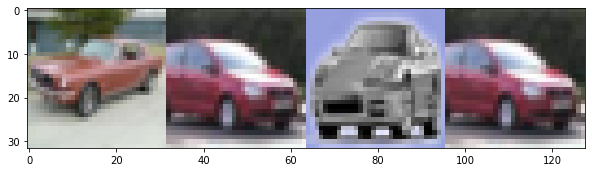

In [10]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch))
plt.show()

In [11]:
# predictions
print(' '.join('%9s' % classes[y_pred[j]] for j in range(4)))

      car     plane     plane     plane


## Evaluation 

Complete the class method `calc_accuracy`. Explain why the accuracy on the training dataset (remember, the model is not trained yet) is around 50%. **(5 Points)**

In [40]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  0.5582


Your answer here: **Currently weights are assigned randomely, therefore, the classification is also random. Since we have 2 classes, the accuracy should be around 50% (random classification between two classes)**

## Perceptron loss

Your code for this section will all be written in the next cell. In this section, we write and test code outside the classes for convenience. Notice the loss method for each class is just a call for the loss function written in the next cell. Once you are finished with implementation, everything should work.

First, complete the function `perceptron_loss_naive`. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W.  **(15 points)**

In [13]:
def perceptron_loss_naive(W, X, y):
    """
    Structured perceptron loss function, naive implementation (with loops)
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with labels 0...K-1, for K classes
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # TODO:                                                                     #
    # Compute the perceptron loss as learned in class. Start by iterating over  #
    # over all instances and calculate the score and true score for each.       #
    # Now, for each class determine if the prediction is correct and update the #
    # loss over all mistakes.                                                   #
    # Compute the gradient of the loss function and store it as dW.             #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed.                                                   #
    #############################################################################
   
    num_instances = X.shape[0]
    t = np.where(y == 1, 1 , -1)   
    
    for i in range(num_instances):
        z_i = np.dot(X[i], W)
        t_i = t[i]
        tz_i = np.dot(z_i, t_i)
        loss = np.float64(loss) + max(0, -tz_i)
        
        tx_i = X[i].T * t[i]
        if tz_i < 0:
            dW[:, 0] = dW[:, 0] - tx_i     
        
    loss = loss / num_instances
    dW = dW / num_instances
    
#     print(f'X: {X.shape} W: {W.shape} z_i: {z_i.shape} t_i: {t_i.shape} tz_i: {tz_i.shape} tx_i: {tx_i.shape}')

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [14]:
# weights are of the form FEATURES X CLASS (in the binary case CLASS=1)
W = np.random.randn(3073, 1) * 0.0001

In [15]:
%%time
loss_naive, grad_naive = perceptron_loss_naive(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 0.165343
Wall time: 33.9 ms


Once your code works, complete the function `perceptron_loss_vectorized` and compare the results of the two functions using the cell below. **(15 points)**

In [16]:
def perceptron_loss_vectorized(W, X, y):
    """
    Vectorized version of perceptron_loss_naive. instead of loops, should use 
    numpy vectorization.

    Inputs and outputs are the same as perceptron_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the perceptron loss, storing the       #
    # result in loss and the gradient in dW                                     #
    #############################################################################
    
    num_instances = X.shape[0]
    t = np.where(y == 1, 1 , -1)
    
    z = np.dot(X, W.flatten())
    tz = z * t
    loss = np.sum(np.fmax(0, -tz))
    
    mask = np.zeros(z.shape)
    mask[tz < 0] = 1
    tx = X.T.dot(t.reshape(num_instances,1))
    dw1 = mask * t
    dW = -X.T.dot(dw1.reshape(num_instances,1))

    loss = loss / num_instances
    dW = dW / num_instances
    
#     print(f'X: {X.shape} W: {W.shape} z: {z.shape} t: {t.shape} tz: {tz.shape} tx: {tx.shape}')
              
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [17]:
%%time

loss_vectorized, grad_vectorized = perceptron_loss_vectorized(W, X_val, y_val)
print ('loss: %f' % (loss_vectorized, ))

difference = np.linalg.norm(grad_naive - grad_vectorized)
print ('difference: %f' % difference)

loss: 0.165343
difference: 0.000000
Wall time: 4.99 ms


We have obtained an efficient function for loss and gradient calculation and we can now train our network. Complete the function `train` in the `LinearClassifier` class. (**10 points**)

In [18]:
%%time
perceptron = LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, learning_rate=1e-7, 
                                num_iters=1500, verbose=True)

iteration 0 / 1500: loss 0.096305
iteration 100 / 1500: loss 0.036071
iteration 200 / 1500: loss 0.031973
iteration 300 / 1500: loss 0.018310
iteration 400 / 1500: loss 0.021685
iteration 500 / 1500: loss 0.017389
iteration 600 / 1500: loss 0.019557
iteration 700 / 1500: loss 0.016342
iteration 800 / 1500: loss 0.022211
iteration 900 / 1500: loss 0.018226
iteration 1000 / 1500: loss 0.015410
iteration 1100 / 1500: loss 0.013330
iteration 1200 / 1500: loss 0.011752
iteration 1300 / 1500: loss 0.013756
iteration 1400 / 1500: loss 0.013250
Wall time: 7.47 s


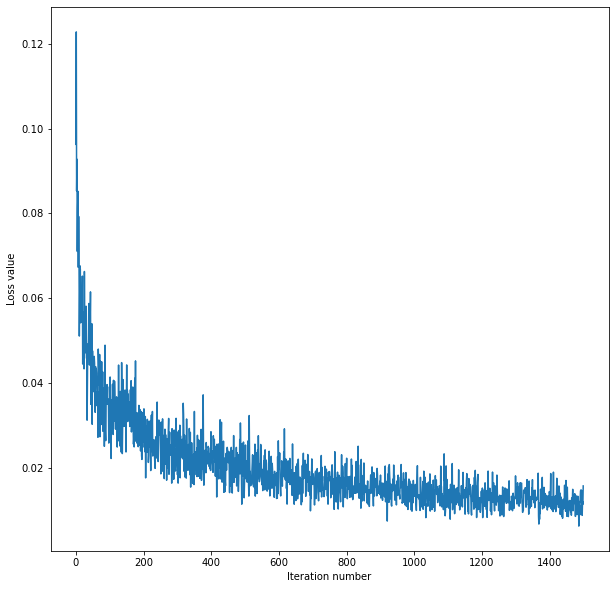

In [19]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [20]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

Training accuracy:  0.7684
Testing accuracy:  0.757


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? 

Your answer here: 
**In my initial hypterparameter optimization process with the given combinations I couldnt see any statistical significance differences between the varies learning rates and batch sizes combinations. Therfore I iterate the prcoess a few times, and took the average training and validation accuracy for each combination, while also adding new learning rates and batch sizes combinations (the uncommented code)**

**After several experiments, i've noticed several times that when the learning rate increase, the accuracy less significantly decrease with large batch_sizes. which aligned with the class theoretical matrial. As we learned, a mini-batch gradient descent has a smoother convergence than SGD, and the larger the batch size, the smoother the convergences which allows a larger learning rates**

**(5 points)**

In [41]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_perceptron = None # The LinearPerceptron object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################

for lr in learning_rates:
    for batch_size in batch_sizes:
        results[(lr, batch_size)] = (0,0)
        
for (lr, batch_size) in results.keys():
    num_iterations = int(120000/batch_size)
    perceptron = LinearPerceptron(X_train, y_train)
    loss_history = perceptron.train(X_train, y_train, 
                             learning_rate=lr,
                             batch_size=batch_size,
                             num_iters=num_iterations,
                             verbose=True)
    training_accuracy = perceptron.calc_accuracy(X_train, y_train)
    validation_accuracy = perceptron.calc_accuracy(X_val, y_val)
    results[(lr, batch_size)] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_perceptron = perceptron
    print("\n")

# # iterating the Hyperparameter optimization prcoess few times with more combinations:

# learning_rates = [5e-7, 2.5e-7, 1e-7, 7.5e-6, 5e-6, 2.5e-6]
# learning_rates = [1e-7, 5e-6, 1e-5, 1e-4, 5e-3, 5e-2]
# batch_sizes = [1, 5, 25, 100, 200, 500]
# for lr in learning_rates:
#     for batch_size in batch_sizes:
#         results[(lr, batch_size)] = (0,0)
# for (lr, batch_size) in results.keys():
#     training_accuracy = []
#     validation_accuracy = []
#     for _ in range(5):
#         num_iterations = int(120000/batch_size)
#         perceptron = LinearPerceptron(X_train, y_train)
#         loss_history = perceptron.train(X_train, y_train, 
#                                  learning_rate=lr,
#                                  batch_size=batch_size,
#                                  num_iters=num_iterations,
#                                  verbose=True)
#         if perceptron.calc_accuracy(X_val, y_val) > best_val:
#             best_val = perceptron.calc_accuracy(X_val, y_val)
#             best_perceptron = perceptron
#         training_accuracy.append(perceptron.calc_accuracy(X_train, y_train))
#         validation_accuracy.append(perceptron.calc_accuracy(X_val, y_val))
#         print("\n")
#     avg_training_accuracy = sum(training_accuracy) / len(training_accuracy)
#     avg_validation_accuracy = sum(validation_accuracy) / len(validation_accuracy)
#     results[(lr, batch_size)] = (avg_training_accuracy, avg_validation_accuracy)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('linear perceptron on raw pixels final test set accuracy: %f' % test_accuracy)

iteration 0 / 120000: loss 0.059700
iteration 100 / 120000: loss 0.833893
iteration 200 / 120000: loss 0.000000
iteration 300 / 120000: loss 0.000000
iteration 400 / 120000: loss 0.000000
iteration 500 / 120000: loss 1.185071
iteration 600 / 120000: loss 0.000000
iteration 700 / 120000: loss 0.124939
iteration 800 / 120000: loss 0.000000
iteration 900 / 120000: loss 0.000000
iteration 1000 / 120000: loss 0.000000
iteration 1100 / 120000: loss 0.000000
iteration 1200 / 120000: loss 0.019732
iteration 1300 / 120000: loss 0.726559
iteration 1400 / 120000: loss 0.000000
iteration 1500 / 120000: loss 0.025505
iteration 1600 / 120000: loss 0.472165
iteration 1700 / 120000: loss 0.000000
iteration 1800 / 120000: loss 0.899653
iteration 1900 / 120000: loss 0.000000
iteration 2000 / 120000: loss 0.596341
iteration 2100 / 120000: loss 0.292310
iteration 2200 / 120000: loss 0.000000
iteration 2300 / 120000: loss 0.000000
iteration 2400 / 120000: loss 0.000000
iteration 2500 / 120000: loss 0.00000

iteration 21000 / 120000: loss 0.000000
iteration 21100 / 120000: loss 0.000000
iteration 21200 / 120000: loss 0.000000
iteration 21300 / 120000: loss 0.000000
iteration 21400 / 120000: loss 0.000000
iteration 21500 / 120000: loss 0.000000
iteration 21600 / 120000: loss 0.000000
iteration 21700 / 120000: loss 0.000000
iteration 21800 / 120000: loss 0.000000
iteration 21900 / 120000: loss 0.026900
iteration 22000 / 120000: loss 0.854995
iteration 22100 / 120000: loss 0.680198
iteration 22200 / 120000: loss 1.531476
iteration 22300 / 120000: loss 0.000000
iteration 22400 / 120000: loss 0.000000
iteration 22500 / 120000: loss 0.055168
iteration 22600 / 120000: loss 0.000000
iteration 22700 / 120000: loss 0.000000
iteration 22800 / 120000: loss 0.000000
iteration 22900 / 120000: loss 0.000000
iteration 23000 / 120000: loss 0.000000
iteration 23100 / 120000: loss 0.000000
iteration 23200 / 120000: loss 0.000000
iteration 23300 / 120000: loss 0.000000
iteration 23400 / 120000: loss 0.000000


iteration 42700 / 120000: loss 0.016682
iteration 42800 / 120000: loss 0.000000
iteration 42900 / 120000: loss 0.000000
iteration 43000 / 120000: loss 0.000000
iteration 43100 / 120000: loss 0.000000
iteration 43200 / 120000: loss 0.000000
iteration 43300 / 120000: loss 0.000000
iteration 43400 / 120000: loss 0.023958
iteration 43500 / 120000: loss 0.000000
iteration 43600 / 120000: loss 0.000000
iteration 43700 / 120000: loss 0.000000
iteration 43800 / 120000: loss 0.000000
iteration 43900 / 120000: loss 2.079023
iteration 44000 / 120000: loss 0.822923
iteration 44100 / 120000: loss 0.000000
iteration 44200 / 120000: loss 0.000000
iteration 44300 / 120000: loss 0.000000
iteration 44400 / 120000: loss 0.000000
iteration 44500 / 120000: loss 0.000000
iteration 44600 / 120000: loss 0.000000
iteration 44700 / 120000: loss 0.974382
iteration 44800 / 120000: loss 0.000000
iteration 44900 / 120000: loss 0.000000
iteration 45000 / 120000: loss 0.000000
iteration 45100 / 120000: loss 0.000000


iteration 64200 / 120000: loss 0.000000
iteration 64300 / 120000: loss 0.000000
iteration 64400 / 120000: loss 0.000000
iteration 64500 / 120000: loss 0.007625
iteration 64600 / 120000: loss 0.000000
iteration 64700 / 120000: loss 0.000000
iteration 64800 / 120000: loss 0.192294
iteration 64900 / 120000: loss 0.000000
iteration 65000 / 120000: loss 0.000000
iteration 65100 / 120000: loss 0.000000
iteration 65200 / 120000: loss 0.914821
iteration 65300 / 120000: loss 3.152709
iteration 65400 / 120000: loss 0.000000
iteration 65500 / 120000: loss 0.000000
iteration 65600 / 120000: loss 0.291908
iteration 65700 / 120000: loss 0.883801
iteration 65800 / 120000: loss 0.000000
iteration 65900 / 120000: loss 0.000000
iteration 66000 / 120000: loss 0.000000
iteration 66100 / 120000: loss 1.586753
iteration 66200 / 120000: loss 0.633394
iteration 66300 / 120000: loss 0.000000
iteration 66400 / 120000: loss 0.000000
iteration 66500 / 120000: loss 0.000000
iteration 66600 / 120000: loss 0.000000


iteration 84800 / 120000: loss 0.000000
iteration 84900 / 120000: loss 0.000000
iteration 85000 / 120000: loss 0.045331
iteration 85100 / 120000: loss 0.000000
iteration 85200 / 120000: loss 1.582383
iteration 85300 / 120000: loss 0.000000
iteration 85400 / 120000: loss 0.000000
iteration 85500 / 120000: loss 0.000000
iteration 85600 / 120000: loss 0.000000
iteration 85700 / 120000: loss 0.000000
iteration 85800 / 120000: loss 0.000000
iteration 85900 / 120000: loss 0.000000
iteration 86000 / 120000: loss 0.000000
iteration 86100 / 120000: loss 0.000000
iteration 86200 / 120000: loss 0.000000
iteration 86300 / 120000: loss 0.000000
iteration 86400 / 120000: loss 0.000000
iteration 86500 / 120000: loss 0.088384
iteration 86600 / 120000: loss 0.000000
iteration 86700 / 120000: loss 0.000000
iteration 86800 / 120000: loss 0.000000
iteration 86900 / 120000: loss 0.000000
iteration 87000 / 120000: loss 0.000000
iteration 87100 / 120000: loss 0.000000
iteration 87200 / 120000: loss 0.000000


iteration 107100 / 120000: loss 0.000000
iteration 107200 / 120000: loss 0.000000
iteration 107300 / 120000: loss 0.125850
iteration 107400 / 120000: loss 0.000000
iteration 107500 / 120000: loss 0.000000
iteration 107600 / 120000: loss 0.000000
iteration 107700 / 120000: loss 0.000000
iteration 107800 / 120000: loss 0.000000
iteration 107900 / 120000: loss 0.000000
iteration 108000 / 120000: loss 0.000000
iteration 108100 / 120000: loss 0.000000
iteration 108200 / 120000: loss 0.000000
iteration 108300 / 120000: loss 0.000000
iteration 108400 / 120000: loss 0.000000
iteration 108500 / 120000: loss 1.612769
iteration 108600 / 120000: loss 0.000000
iteration 108700 / 120000: loss 0.000000
iteration 108800 / 120000: loss 0.065352
iteration 108900 / 120000: loss 0.000000
iteration 109000 / 120000: loss 0.301230
iteration 109100 / 120000: loss 0.000000
iteration 109200 / 120000: loss 0.000000
iteration 109300 / 120000: loss 0.366629
iteration 109400 / 120000: loss 0.000000
iteration 109500

iteration 5900 / 120000: loss 0.000000
iteration 6000 / 120000: loss 0.000000
iteration 6100 / 120000: loss 0.000000
iteration 6200 / 120000: loss 0.000000
iteration 6300 / 120000: loss 70.667123
iteration 6400 / 120000: loss 0.000000
iteration 6500 / 120000: loss 84.423059
iteration 6600 / 120000: loss 0.000000
iteration 6700 / 120000: loss 23.542684
iteration 6800 / 120000: loss 27.048417
iteration 6900 / 120000: loss 0.000000
iteration 7000 / 120000: loss 0.000000
iteration 7100 / 120000: loss 0.000000
iteration 7200 / 120000: loss 0.000000
iteration 7300 / 120000: loss 0.000000
iteration 7400 / 120000: loss 7.708764
iteration 7500 / 120000: loss 0.000000
iteration 7600 / 120000: loss 0.000000
iteration 7700 / 120000: loss 0.000000
iteration 7800 / 120000: loss 0.000000
iteration 7900 / 120000: loss 19.617573
iteration 8000 / 120000: loss 0.000000
iteration 8100 / 120000: loss 0.000000
iteration 8200 / 120000: loss 0.000000
iteration 8300 / 120000: loss 0.000000
iteration 8400 / 120

iteration 27700 / 120000: loss 0.000000
iteration 27800 / 120000: loss 0.000000
iteration 27900 / 120000: loss 0.000000
iteration 28000 / 120000: loss 0.000000
iteration 28100 / 120000: loss 0.000000
iteration 28200 / 120000: loss 0.000000
iteration 28300 / 120000: loss 5.339742
iteration 28400 / 120000: loss 0.000000
iteration 28500 / 120000: loss 0.000000
iteration 28600 / 120000: loss 38.601809
iteration 28700 / 120000: loss 27.501263
iteration 28800 / 120000: loss 0.000000
iteration 28900 / 120000: loss 43.480935
iteration 29000 / 120000: loss 0.000000
iteration 29100 / 120000: loss 0.000000
iteration 29200 / 120000: loss 0.000000
iteration 29300 / 120000: loss 0.000000
iteration 29400 / 120000: loss 0.000000
iteration 29500 / 120000: loss 16.691266
iteration 29600 / 120000: loss 0.000000
iteration 29700 / 120000: loss 0.000000
iteration 29800 / 120000: loss 0.000000
iteration 29900 / 120000: loss 0.000000
iteration 30000 / 120000: loss 0.000000
iteration 30100 / 120000: loss 8.280

iteration 48300 / 120000: loss 0.000000
iteration 48400 / 120000: loss 0.000000
iteration 48500 / 120000: loss 0.000000
iteration 48600 / 120000: loss 0.000000
iteration 48700 / 120000: loss 0.000000
iteration 48800 / 120000: loss 0.000000
iteration 48900 / 120000: loss 0.000000
iteration 49000 / 120000: loss 55.944913
iteration 49100 / 120000: loss 27.165507
iteration 49200 / 120000: loss 0.000000
iteration 49300 / 120000: loss 0.000000
iteration 49400 / 120000: loss 0.000000
iteration 49500 / 120000: loss 0.000000
iteration 49600 / 120000: loss 0.000000
iteration 49700 / 120000: loss 17.683513
iteration 49800 / 120000: loss 0.000000
iteration 49900 / 120000: loss 6.545163
iteration 50000 / 120000: loss 4.396621
iteration 50100 / 120000: loss 0.000000
iteration 50200 / 120000: loss 0.000000
iteration 50300 / 120000: loss 21.113277
iteration 50400 / 120000: loss 0.000000
iteration 50500 / 120000: loss 0.000000
iteration 50600 / 120000: loss 0.000000
iteration 50700 / 120000: loss 0.000

iteration 69100 / 120000: loss 0.000000
iteration 69200 / 120000: loss 0.000000
iteration 69300 / 120000: loss 0.000000
iteration 69400 / 120000: loss 0.000000
iteration 69500 / 120000: loss 0.000000
iteration 69600 / 120000: loss 28.212834
iteration 69700 / 120000: loss 0.000000
iteration 69800 / 120000: loss 0.000000
iteration 69900 / 120000: loss 0.000000
iteration 70000 / 120000: loss 0.000000
iteration 70100 / 120000: loss 0.000000
iteration 70200 / 120000: loss 0.000000
iteration 70300 / 120000: loss 46.751801
iteration 70400 / 120000: loss 6.509810
iteration 70500 / 120000: loss 0.000000
iteration 70600 / 120000: loss 0.000000
iteration 70700 / 120000: loss 12.870367
iteration 70800 / 120000: loss 0.000000
iteration 70900 / 120000: loss 8.511382
iteration 71000 / 120000: loss 0.000000
iteration 71100 / 120000: loss 1.813892
iteration 71200 / 120000: loss 0.000000
iteration 71300 / 120000: loss 44.467600
iteration 71400 / 120000: loss 0.000000
iteration 71500 / 120000: loss 0.000

iteration 90500 / 120000: loss 0.000000
iteration 90600 / 120000: loss 0.000000
iteration 90700 / 120000: loss 0.000000
iteration 90800 / 120000: loss 0.000000
iteration 90900 / 120000: loss 0.000000
iteration 91000 / 120000: loss 0.000000
iteration 91100 / 120000: loss 116.839523
iteration 91200 / 120000: loss 0.000000
iteration 91300 / 120000: loss 0.000000
iteration 91400 / 120000: loss 0.000000
iteration 91500 / 120000: loss 0.000000
iteration 91600 / 120000: loss 0.000000
iteration 91700 / 120000: loss 0.000000
iteration 91800 / 120000: loss 0.000000
iteration 91900 / 120000: loss 34.239716
iteration 92000 / 120000: loss 0.000000
iteration 92100 / 120000: loss 0.000000
iteration 92200 / 120000: loss 10.720591
iteration 92300 / 120000: loss 0.000000
iteration 92400 / 120000: loss 0.000000
iteration 92500 / 120000: loss 0.000000
iteration 92600 / 120000: loss 0.000000
iteration 92700 / 120000: loss 0.000000
iteration 92800 / 120000: loss 0.000000
iteration 92900 / 120000: loss 0.000

iteration 111200 / 120000: loss 0.000000
iteration 111300 / 120000: loss 10.567112
iteration 111400 / 120000: loss 0.000000
iteration 111500 / 120000: loss 0.000000
iteration 111600 / 120000: loss 0.000000
iteration 111700 / 120000: loss 37.737653
iteration 111800 / 120000: loss 0.000000
iteration 111900 / 120000: loss 0.000000
iteration 112000 / 120000: loss 27.609595
iteration 112100 / 120000: loss 0.000000
iteration 112200 / 120000: loss 0.000000
iteration 112300 / 120000: loss 48.307997
iteration 112400 / 120000: loss 0.000000
iteration 112500 / 120000: loss 0.000000
iteration 112600 / 120000: loss 0.000000
iteration 112700 / 120000: loss 0.000000
iteration 112800 / 120000: loss 117.068563
iteration 112900 / 120000: loss 0.000000
iteration 113000 / 120000: loss 0.000000
iteration 113100 / 120000: loss 0.000000
iteration 113200 / 120000: loss 0.000000
iteration 113300 / 120000: loss 0.000000
iteration 113400 / 120000: loss 0.000000
iteration 113500 / 120000: loss 0.000000
iteration 

## Logistic regression

Another choice for a binary classifier is the binary logistic regression classifier. Unlike the perceptron which treats the outputs as uncalibrated and possibly difficult to interpret scores for each class, the binary logistic regression classifier gives a slightly more intuitive output in the form of normalized class probabilities. In this classifier, the function mapping $f(x_i; W, b) = W\cdot x_i + b$ stays unchanged but we now interpret these scores as the unnormalized log probabilities for each class and replace the perceptron loss with a cross-entropy loss. In this exercise, we will define our binary logistic regression classifier to have one input.       

Read the next code cell. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class - remember you need to implement the sigmoid function before you can obtain predictions using your classifier.

**Important note**: values passed to the `sigmoid` function can be arbitrarily large or small. When we take the exponent of such values, we might encounter extreme values that might *overflow*. This is known as numerical instability and you should always take care when you use exponent in your functions. **(10 Points)**

In [4]:
def sigmoid(x):
    """
    Numerically stable Sigmoid function.

    Input: any unnormalized log probabilities vector
    Output: normalized probabilities
    """
    #############################################################################
    # TODO:                                                                     #
    # Implement the function                                                    #
    #############################################################################
    
    result = None
    x_bounded = np.where(x > 100, 100 , x)
    x_bounded = np.where(x < -100, -100 , x_bounded)
    result = (1. / (1. + np.exp(-x_bounded)))
    return result

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

In [6]:
sigmoid(0)

0.5

In [23]:
class LogisticRegression(LinearClassifier):
    # Classifer that uses sigmoid and binary cross entropy loss
    def __init__(self, X, y):
        self.W = None
        ###########################################################################
        # TODO:                                                                   #
        # Initiate the parameters of your model.                                  #
        ###########################################################################

        num_features = X.shape[1]
        self.W  = np.random.randn(num_features, 1) * 0.0001

        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################


    def predict(self, X):
        y_pred = None
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method.                                                  #
        ###########################################################################

        z = np.dot(X, self.W)
        probability = sigmoid(z)
        y_pred = np.where(probability > 0.5, 1 , 0).flatten()
        
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred


    def loss(self, X_batch, y_batch):
        return binary_cross_entropy(self.W, X_batch, y_batch)

In [24]:
logistic = LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)

    plane       car     plane       car


<ipython-input-5-53f36cc3ba39>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images]))


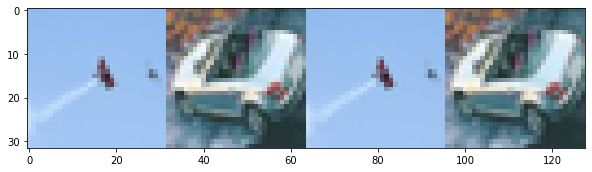

In [25]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [26]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

          car           car         plane         plane


In [27]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

model accuracy:  0.5406


## Binary cross-entropy

Your code for this section will written in the next cell. 

Complete the function `binary_cross_entropy` using vectorized code. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W. (**20 points**)

In [28]:
def binary_cross_entropy(W, X, y):
    """
    Structured BCE loss function. Implement this function using vectorized code.
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with binary labels (0,1). 
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # TODO:                                                                     #
    # Implement the function and store result in loss and the gradint in dW     #
    # Note: in class you defined BCE that takes values from the range (-1,1).   #
    # and the sigmoid function generally outputs values in the range (0,1).     #
    # Make the proper adjustments for your code to work.                        #
    #############################################################################
    
    num_instances = X.shape[0]
    t = np.where(y == 1, 1 , -1).flatten()
    
    z = np.dot(X, W.flatten())
    tz = z * t
    loss =  - np.sum(np.log(sigmoid(tz)))
    dw1 = sigmoid(-t * z) * t
    dw2 = dw1.reshape(X.shape[0], 1) * X
    dW =  - np.sum(dw2, axis=0).reshape(W.shape[0], 1)

    loss = loss / num_instances
    dW = dW / num_instances
    
#     print(f'X: {X.shape} W: {W.shape} z: {z.shape} t: {t.shape} tz: {tz.shape}')
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [29]:
W = np.random.randn(3073, 1) * 0.0001

In [30]:
%%time
loss_naive, grad_naive = binary_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 0.637483
Wall time: 31.4 ms


You are provided with a gradient test in the next cells:

In [31]:
def grad_check(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [32]:
loss, grad = binary_cross_entropy(W, X_val, y_val)
f = lambda w: binary_cross_entropy(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

numerical: 1.303431 analytic: 1.303431, relative error: 5.713321e-08
numerical: 3.332904 analytic: 3.332904, relative error: 4.120035e-08
numerical: -0.178215 analytic: -0.178215, relative error: 8.319657e-07
numerical: 3.517437 analytic: 3.517436, relative error: 5.008573e-08
numerical: 7.532726 analytic: 7.532725, relative error: 2.506808e-08
numerical: 6.293226 analytic: 6.293225, relative error: 2.882049e-08
numerical: 8.605297 analytic: 8.605297, relative error: 1.834610e-08
numerical: 2.233571 analytic: 2.233571, relative error: 6.790515e-08
numerical: 0.857777 analytic: 0.857777, relative error: 1.448212e-07
numerical: 1.005215 analytic: 1.005215, relative error: 9.829341e-08


If implemented correctly, the training procedure you already implemented should work.

In [33]:
%%time
logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

iteration 0 / 1500: loss 0.705304
iteration 100 / 1500: loss 0.496872
iteration 200 / 1500: loss 0.498208
iteration 300 / 1500: loss 0.425836
iteration 400 / 1500: loss 0.518878
iteration 500 / 1500: loss 0.496099
iteration 600 / 1500: loss 0.434114
iteration 700 / 1500: loss 0.422720
iteration 800 / 1500: loss 0.446480
iteration 900 / 1500: loss 0.434895
iteration 1000 / 1500: loss 0.446956
iteration 1100 / 1500: loss 0.447770
iteration 1200 / 1500: loss 0.438873
iteration 1300 / 1500: loss 0.378066
iteration 1400 / 1500: loss 0.418841
Wall time: 14.9 s


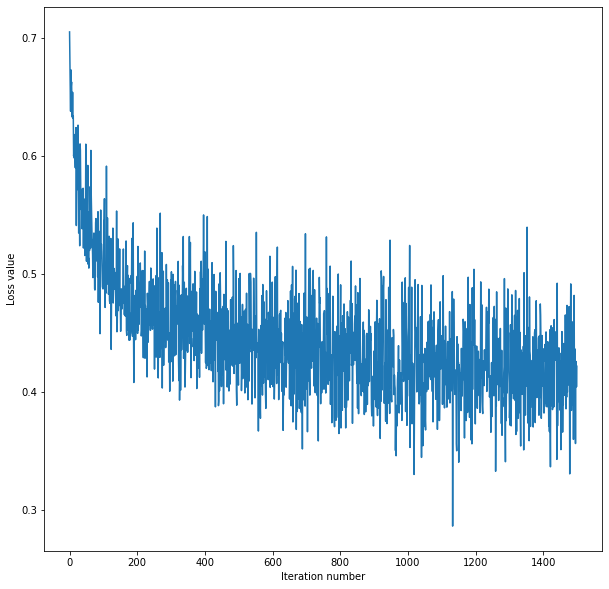

In [34]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [35]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))


Training accuracy:  0.813
Testing accuracy:  0.822


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? 

Your answer here: **As in  the perceptron experiment, In my initial hypterparameter optimization process with the given combinations I couldnt see any statistical significance differences between the varies learning rates and batch sizes combinations. Therfore I iterate the prcoess a few times, and took the average training and validation accuracy for each combination, while also adding new learning rates and batch sizes combinations (the uncommented code)**

**After several experiments, i've noticed several times that when the learning rate increase, the accuracy less significantly decrease with large batch_sizes. which aligned with the class theoretical matrial. As we learned, a mini-batch gradient descent has a smoother convergence than SGD, and the larger the batch size, the smoother the convergences which allows a larger learning rates**

**(5 points)**

In [36]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################

for lr in learning_rates:
    for batch_size in batch_sizes:
        results[(lr, batch_size)] = (0,0)
for (lr, batch_size) in results.keys():
    num_iterations = int(120000/batch_size)
    logistic = LogisticRegression(X_train, y_train)
    loss_history = logistic.train(X_train, y_train, 
                             learning_rate=lr,
                             batch_size=batch_size,
                             num_iters=num_iterations,
                             verbose=True)
    training_accuracy = logistic.calc_accuracy(X_train, y_train)
    validation_accuracy = logistic.calc_accuracy(X_val, y_val)
    results[(lr, batch_size)] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_logistic = logistic
    print("\n")

# # iterating the Hyperparameter optimization prcoess few times with more combinations:

# learning_rates = [5e-7, 2.5e-7, 1e-7, 7.5e-6, 5e-6, 2.5e-6]
# learning_rates = [1e-7, 5e-6, 1e-5, 1e-4, 5e-3, 5e-2]
# batch_sizes = [1, 5, 25, 100, 200, 500]
# for lr in learning_rates:
#     for batch_size in batch_sizes:
#         results[(lr, batch_size)] = (0,0)
# for (lr, batch_size) in results.keys():
#     training_accuracy = []
#     validation_accuracy = []
#     for _ in range(10):
#         num_iterations = int(120000/batch_size)
#         logistic = LogisticRegression(X_train, y_train)
#         loss_history = logistic.train(X_train, y_train, 
#                                  learning_rate=lr,
#                                  batch_size=batch_size,
#                                  num_iters=num_iterations,
#                                  verbose=True)
#         if logistic.calc_accuracy(X_val, y_val) > best_val:
#             best_val = logistic.calc_accuracy(X_val, y_val)
#             best_logistic = logistic
#         training_accuracy.append(logistic.calc_accuracy(X_train, y_train))
#         validation_accuracy.append(logistic.calc_accuracy(X_val, y_val))
#         print("\n")
#     avg_training_accuracy = sum(training_accuracy) / len(training_accuracy)
#     avg_validation_accuracy = sum(validation_accuracy) / len(validation_accuracy)
#     results[(lr, batch_size)] = (avg_training_accuracy, avg_validation_accuracy)
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_logistic.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

iteration 0 / 120000: loss 0.992989
iteration 100 / 120000: loss 0.151618
iteration 200 / 120000: loss 0.197921
iteration 300 / 120000: loss 0.653869
iteration 400 / 120000: loss 0.948614
iteration 500 / 120000: loss 0.149312
iteration 600 / 120000: loss 0.798377
iteration 700 / 120000: loss 0.153429
iteration 800 / 120000: loss 0.155879
iteration 900 / 120000: loss 0.450681
iteration 1000 / 120000: loss 0.306876
iteration 1100 / 120000: loss 0.042598
iteration 1200 / 120000: loss 0.106452
iteration 1300 / 120000: loss 0.700469
iteration 1400 / 120000: loss 0.541782
iteration 1500 / 120000: loss 0.628652
iteration 1600 / 120000: loss 0.501611
iteration 1700 / 120000: loss 0.392226
iteration 1800 / 120000: loss 0.108775
iteration 1900 / 120000: loss 0.115965
iteration 2000 / 120000: loss 1.012208
iteration 2100 / 120000: loss 0.645720
iteration 2200 / 120000: loss 0.110546
iteration 2300 / 120000: loss 0.072929
iteration 2400 / 120000: loss 0.120379
iteration 2500 / 120000: loss 4.56951

iteration 21200 / 120000: loss 0.074620
iteration 21300 / 120000: loss 0.399988
iteration 21400 / 120000: loss 0.039340
iteration 21500 / 120000: loss 0.019888
iteration 21600 / 120000: loss 0.239492
iteration 21700 / 120000: loss 0.666196
iteration 21800 / 120000: loss 0.014414
iteration 21900 / 120000: loss 0.450606
iteration 22000 / 120000: loss 0.200748
iteration 22100 / 120000: loss 0.014800
iteration 22200 / 120000: loss 0.453463
iteration 22300 / 120000: loss 0.004319
iteration 22400 / 120000: loss 0.067700
iteration 22500 / 120000: loss 0.147484
iteration 22600 / 120000: loss 1.495805
iteration 22700 / 120000: loss 0.009034
iteration 22800 / 120000: loss 0.024619
iteration 22900 / 120000: loss 0.175600
iteration 23000 / 120000: loss 0.058630
iteration 23100 / 120000: loss 0.036856
iteration 23200 / 120000: loss 0.017632
iteration 23300 / 120000: loss 0.328160
iteration 23400 / 120000: loss 0.078687
iteration 23500 / 120000: loss 0.317882
iteration 23600 / 120000: loss 0.652940


iteration 42800 / 120000: loss 0.032464
iteration 42900 / 120000: loss 0.449390
iteration 43000 / 120000: loss 0.023843
iteration 43100 / 120000: loss 0.014770
iteration 43200 / 120000: loss 0.289919
iteration 43300 / 120000: loss 0.458529
iteration 43400 / 120000: loss 0.154902
iteration 43500 / 120000: loss 0.251883
iteration 43600 / 120000: loss 0.083971
iteration 43700 / 120000: loss 0.018076
iteration 43800 / 120000: loss 0.374806
iteration 43900 / 120000: loss 0.009966
iteration 44000 / 120000: loss 0.002295
iteration 44100 / 120000: loss 0.019326
iteration 44200 / 120000: loss 0.158872
iteration 44300 / 120000: loss 0.009239
iteration 44400 / 120000: loss 0.912978
iteration 44500 / 120000: loss 2.751057
iteration 44600 / 120000: loss 0.044266
iteration 44700 / 120000: loss 0.879620
iteration 44800 / 120000: loss 0.240341
iteration 44900 / 120000: loss 0.203026
iteration 45000 / 120000: loss 0.058725
iteration 45100 / 120000: loss 0.090409
iteration 45200 / 120000: loss 0.455861


iteration 63300 / 120000: loss 0.267544
iteration 63400 / 120000: loss 0.485786
iteration 63500 / 120000: loss 0.767605
iteration 63600 / 120000: loss 0.010694
iteration 63700 / 120000: loss 0.003035
iteration 63800 / 120000: loss 0.069140
iteration 63900 / 120000: loss 0.317558
iteration 64000 / 120000: loss 0.298369
iteration 64100 / 120000: loss 0.012906
iteration 64200 / 120000: loss 1.249299
iteration 64300 / 120000: loss 0.010952
iteration 64400 / 120000: loss 0.031618
iteration 64500 / 120000: loss 0.001102
iteration 64600 / 120000: loss 0.053245
iteration 64700 / 120000: loss 0.696943
iteration 64800 / 120000: loss 0.011981
iteration 64900 / 120000: loss 1.074695
iteration 65000 / 120000: loss 0.019975
iteration 65100 / 120000: loss 0.229609
iteration 65200 / 120000: loss 0.144913
iteration 65300 / 120000: loss 0.003796
iteration 65400 / 120000: loss 0.159935
iteration 65500 / 120000: loss 0.122834
iteration 65600 / 120000: loss 0.026865
iteration 65700 / 120000: loss 0.268763


iteration 84900 / 120000: loss 0.180607
iteration 85000 / 120000: loss 0.113541
iteration 85100 / 120000: loss 0.383208
iteration 85200 / 120000: loss 0.547973
iteration 85300 / 120000: loss 0.035448
iteration 85400 / 120000: loss 0.041557
iteration 85500 / 120000: loss 0.040985
iteration 85600 / 120000: loss 0.002676
iteration 85700 / 120000: loss 0.230379
iteration 85800 / 120000: loss 0.086177
iteration 85900 / 120000: loss 0.318797
iteration 86000 / 120000: loss 0.443390
iteration 86100 / 120000: loss 0.000267
iteration 86200 / 120000: loss 0.021077
iteration 86300 / 120000: loss 3.214834
iteration 86400 / 120000: loss 0.006508
iteration 86500 / 120000: loss 0.159255
iteration 86600 / 120000: loss 1.399132
iteration 86700 / 120000: loss 1.707879
iteration 86800 / 120000: loss 0.003410
iteration 86900 / 120000: loss 1.455346
iteration 87000 / 120000: loss 0.000413
iteration 87100 / 120000: loss 0.021331
iteration 87200 / 120000: loss 0.013927
iteration 87300 / 120000: loss 0.016933


iteration 106400 / 120000: loss 0.032215
iteration 106500 / 120000: loss 1.255949
iteration 106600 / 120000: loss 0.625591
iteration 106700 / 120000: loss 1.191087
iteration 106800 / 120000: loss 0.042222
iteration 106900 / 120000: loss 0.008169
iteration 107000 / 120000: loss 0.001861
iteration 107100 / 120000: loss 0.665929
iteration 107200 / 120000: loss 0.716853
iteration 107300 / 120000: loss 0.069262
iteration 107400 / 120000: loss 0.172645
iteration 107500 / 120000: loss 0.452998
iteration 107600 / 120000: loss 0.054715
iteration 107700 / 120000: loss 0.380637
iteration 107800 / 120000: loss 0.000096
iteration 107900 / 120000: loss 0.001308
iteration 108000 / 120000: loss 0.020741
iteration 108100 / 120000: loss 1.162497
iteration 108200 / 120000: loss 1.352956
iteration 108300 / 120000: loss 0.089652
iteration 108400 / 120000: loss 4.135900
iteration 108500 / 120000: loss 0.085016
iteration 108600 / 120000: loss 0.124219
iteration 108700 / 120000: loss 0.004992
iteration 108800

iteration 5400 / 120000: loss -0.000000
iteration 5500 / 120000: loss -0.000000
iteration 5600 / 120000: loss 4.856638
iteration 5700 / 120000: loss -0.000000
iteration 5800 / 120000: loss -0.000000
iteration 5900 / 120000: loss -0.000000
iteration 6000 / 120000: loss -0.000000
iteration 6100 / 120000: loss 0.020197
iteration 6200 / 120000: loss -0.000000
iteration 6300 / 120000: loss 41.496106
iteration 6400 / 120000: loss 12.357889
iteration 6500 / 120000: loss 0.000000
iteration 6600 / 120000: loss -0.000000
iteration 6700 / 120000: loss -0.000000
iteration 6800 / 120000: loss -0.000000
iteration 6900 / 120000: loss 59.411383
iteration 7000 / 120000: loss 43.676080
iteration 7100 / 120000: loss -0.000000
iteration 7200 / 120000: loss -0.000000
iteration 7300 / 120000: loss -0.000000
iteration 7400 / 120000: loss -0.000000
iteration 7500 / 120000: loss 0.000000
iteration 7600 / 120000: loss -0.000000
iteration 7700 / 120000: loss 36.914260
iteration 7800 / 120000: loss -0.000000
iter

iteration 26500 / 120000: loss -0.000000
iteration 26600 / 120000: loss 2.369362
iteration 26700 / 120000: loss 0.000000
iteration 26800 / 120000: loss -0.000000
iteration 26900 / 120000: loss -0.000000
iteration 27000 / 120000: loss -0.000000
iteration 27100 / 120000: loss 0.000044
iteration 27200 / 120000: loss -0.000000
iteration 27300 / 120000: loss -0.000000
iteration 27400 / 120000: loss 0.126977
iteration 27500 / 120000: loss 16.133844
iteration 27600 / 120000: loss -0.000000
iteration 27700 / 120000: loss -0.000000
iteration 27800 / 120000: loss 0.001592
iteration 27900 / 120000: loss 0.000000
iteration 28000 / 120000: loss 21.121299
iteration 28100 / 120000: loss 22.248780
iteration 28200 / 120000: loss 0.000000
iteration 28300 / 120000: loss -0.000000
iteration 28400 / 120000: loss -0.000000
iteration 28500 / 120000: loss -0.000000
iteration 28600 / 120000: loss 0.000000
iteration 28700 / 120000: loss 18.498100
iteration 28800 / 120000: loss -0.000000
iteration 28900 / 120000

iteration 47200 / 120000: loss 0.000004
iteration 47300 / 120000: loss -0.000000
iteration 47400 / 120000: loss -0.000000
iteration 47500 / 120000: loss 10.395263
iteration 47600 / 120000: loss 0.160949
iteration 47700 / 120000: loss 18.658108
iteration 47800 / 120000: loss 0.006007
iteration 47900 / 120000: loss 11.826758
iteration 48000 / 120000: loss -0.000000
iteration 48100 / 120000: loss 0.000011
iteration 48200 / 120000: loss -0.000000
iteration 48300 / 120000: loss -0.000000
iteration 48400 / 120000: loss 0.000000
iteration 48500 / 120000: loss -0.000000
iteration 48600 / 120000: loss 0.000000
iteration 48700 / 120000: loss -0.000000
iteration 48800 / 120000: loss -0.000000
iteration 48900 / 120000: loss 1.304321
iteration 49000 / 120000: loss -0.000000
iteration 49100 / 120000: loss -0.000000
iteration 49200 / 120000: loss 86.726485
iteration 49300 / 120000: loss 0.000000
iteration 49400 / 120000: loss 0.000000
iteration 49500 / 120000: loss 0.848378
iteration 49600 / 120000: 

iteration 67600 / 120000: loss 81.694837
iteration 67700 / 120000: loss -0.000000
iteration 67800 / 120000: loss 0.000008
iteration 67900 / 120000: loss 26.028031
iteration 68000 / 120000: loss -0.000000
iteration 68100 / 120000: loss -0.000000
iteration 68200 / 120000: loss 0.000000
iteration 68300 / 120000: loss 0.000000
iteration 68400 / 120000: loss -0.000000
iteration 68500 / 120000: loss -0.000000
iteration 68600 / 120000: loss 49.742057
iteration 68700 / 120000: loss -0.000000
iteration 68800 / 120000: loss 12.870183
iteration 68900 / 120000: loss -0.000000
iteration 69000 / 120000: loss 0.014687
iteration 69100 / 120000: loss -0.000000
iteration 69200 / 120000: loss -0.000000
iteration 69300 / 120000: loss -0.000000
iteration 69400 / 120000: loss 0.000000
iteration 69500 / 120000: loss 31.826901
iteration 69600 / 120000: loss 0.000000
iteration 69700 / 120000: loss -0.000000
iteration 69800 / 120000: loss -0.000000
iteration 69900 / 120000: loss 68.664105
iteration 70000 / 1200

iteration 88100 / 120000: loss 0.000000
iteration 88200 / 120000: loss -0.000000
iteration 88300 / 120000: loss -0.000000
iteration 88400 / 120000: loss -0.000000
iteration 88500 / 120000: loss -0.000000
iteration 88600 / 120000: loss -0.000000
iteration 88700 / 120000: loss 0.000400
iteration 88800 / 120000: loss 66.493648
iteration 88900 / 120000: loss -0.000000
iteration 89000 / 120000: loss 0.000000
iteration 89100 / 120000: loss 0.000101
iteration 89200 / 120000: loss -0.000000
iteration 89300 / 120000: loss -0.000000
iteration 89400 / 120000: loss 15.266520
iteration 89500 / 120000: loss 3.733507
iteration 89600 / 120000: loss -0.000000
iteration 89700 / 120000: loss 0.000000
iteration 89800 / 120000: loss -0.000000
iteration 89900 / 120000: loss -0.000000
iteration 90000 / 120000: loss 50.090281
iteration 90100 / 120000: loss 0.000000
iteration 90200 / 120000: loss -0.000000
iteration 90300 / 120000: loss -0.000000
iteration 90400 / 120000: loss 0.000000
iteration 90500 / 120000

iteration 109400 / 120000: loss 0.000002
iteration 109500 / 120000: loss -0.000000
iteration 109600 / 120000: loss 10.256251
iteration 109700 / 120000: loss -0.000000
iteration 109800 / 120000: loss 29.564626
iteration 109900 / 120000: loss -0.000000
iteration 110000 / 120000: loss -0.000000
iteration 110100 / 120000: loss 0.000000
iteration 110200 / 120000: loss -0.000000
iteration 110300 / 120000: loss -0.000000
iteration 110400 / 120000: loss 12.164032
iteration 110500 / 120000: loss -0.000000
iteration 110600 / 120000: loss 40.104847
iteration 110700 / 120000: loss 15.573990
iteration 110800 / 120000: loss 0.019312
iteration 110900 / 120000: loss 0.000000
iteration 111000 / 120000: loss 32.323543
iteration 111100 / 120000: loss 6.219644
iteration 111200 / 120000: loss -0.000000
iteration 111300 / 120000: loss 16.465410
iteration 111400 / 120000: loss -0.000000
iteration 111500 / 120000: loss 0.000007
iteration 111600 / 120000: loss -0.000000
iteration 111700 / 120000: loss 47.92721

## Weight Visualization

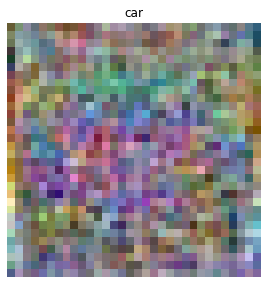

In [37]:
w = best_perceptron.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = ['car']
for i in range(1):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

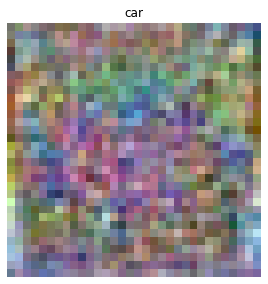

In [38]:
w = best_logistic.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = ['car']
for i in range(1):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

####**Question:** Explain the possible reasons for the differences in the visualization of the weights in the both cases, also are the car weights for the perceptron and logistic models similiar? what can you say about that? **(5 points)**

Your answer here: **Since we are executing two differenet models, it is logical that the car weights won't be identical, and we can notice some differences in the visualizations. But overall, as we can see, the visualization is similar in both cases, meaning the car weights for both models are somewhat alike, which is reasonable since both models are trained on the same car's datasets, and both reached to a similar validation accuracy.** 

# The End!